## 라이브러리 import
---

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow import keras
import tensorflow as tf

import time
import datetime

## 데이터 가져오기
---

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


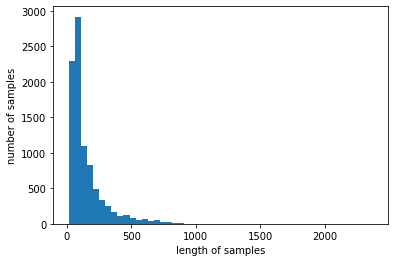

In [5]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [7]:
index_to_word = {index + 3 : word for word, index in word_index.items()}

인덱스에 3을 더해서 뒤로 항목을 밀어놓고, <pad>, <sos>, <unk>를 추가

In [8]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [9]:
x_train[0]

[1,
 27595,
 28842,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [10]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


데이터 변환

In [11]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [12]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

벡터화

DTM

In [13]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


TF-IDF

In [14]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


## 모델 학습
---

In [15]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

In [16]:
#급조결과값 저장용 행렬
bayse = []
cnb = []
logistic = []
svm = []
dtree = []
rf = []
gbs = []
voting = []

bayse_f = []
cnb_f = []
logistic_f = []
svm_f = []
dtree_f = []
rf_f = []
gbs_f = []
voting_f = []

In [17]:
def train_ml(tfidfv, y_train, tfidfv_test, y_test):
    # 나이브 베이즈 분류기 
    mod = MultinomialNB()
    mod.fit(tfidfv, y_train)
    
    mod_predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
    acc = accuracy_score(y_test, mod_predicted)
    f1 = f1_score(y_test, mod_predicted, average='weighted')
    print("나이브 베이즈 정확도: ", acc, "    f1score: ",f1) #예측값과 실제값 비교
    
    bayse.append(acc) # 결과값 저장
    bayse_f.append(f1)
    
    # CNB
    cb = ComplementNB()
    cb.fit(tfidfv, y_train)
    
    cb_predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
    acc = accuracy_score(y_test, cb_predicted)
    f1 = f1_score(y_test, cb_predicted, average='weighted')
    print("CNB 정확도: ", acc, "    f1score: ",f1) #예측값과 실제값 비교    
    cnb.append(acc)
    cnb_f.append(f1)
    
    # 로지스틱 회귀 
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(tfidfv, y_train)

    lr_predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
    acc = accuracy_score(y_test, lr_predicted)
    f1 = f1_score(y_test, lr_predicted, average='weighted')
    print("로지스틱 회귀 정확도: ", acc, "    f1score: ",f1) #예측값과 실제값 비교    
    logistic.append(acc)
    logistic_f.append(f1)
    
    # 선형 서포트 벡터 머신 
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(tfidfv, y_train)
    
    lsvc_predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
    acc = accuracy_score(y_test, lsvc_predicted)
    f1 = f1_score(y_test, lsvc_predicted, average='weighted')
    print("SVM 정확도: ", acc, "    f1score: ",f1) #예측값과 실제값 비교    
    svm.append(acc)
    svm_f.append(f1)
    
    # 결정 트리(Decision Tree) 
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)
    
    tree_predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
    acc = accuracy_score(y_test, tree_predicted)
    f1 = f1_score(y_test, tree_predicted, average='weighted')
    print("결정 트리 정확도: ", acc, "    f1score: ",f1) #예측값과 실제값 비교    
    dtree.append(acc)
    dtree_f.append(f1)
    
    # 랜덤 포레스트(Random Forest)
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(tfidfv, y_train)
    
    forest_predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
    acc = accuracy_score(y_test, forest_predicted)
    f1 = f1_score(y_test, forest_predicted, average='weighted')
    print("랜덤 포레스트 정확도: ", acc, "    f1score: ",f1) #예측값과 실제값 비교    
    rf.append(acc)
    rf_f.append(f1)
    
    # 그래디언트 부스팅 트리(GradientBoostingClassifier)
    grbt = GradientBoostingClassifier(random_state=0, verbose=3) # verbose=3
    grbt.fit(tfidfv, y_train)

    grbt_predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
    acc = accuracy_score(y_test, grbt_predicted)
    f1 = f1_score(y_test, grbt_predicted, average='weighted')
    print("그래디언트 부스팅 트리 정확도: ", acc, "    f1score: ",f1) #예측값과 실제값 비교    
    gbs.append(acc)
    gbs_f.append(f1)
    
    # 보팅(Voting)
    voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
        ], voting='soft', n_jobs=-1)
    voting_classifier.fit(tfidfv, y_train)
    
    voting_classifier_predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
    acc = accuracy_score(y_test, voting_classifier_predicted)
    f1 = f1_score(y_test, voting_classifier_predicted, average='weighted')
    print("보팅 정확도: ", acc, "    f1score: ",f1) #예측값과 실제값 비교    
    voting.append(acc)
    voting_f.append(f1)
    
    print("보팅 정확도:", accuracy_score(y_test, voting_classifier_predicted)) #예측값과 실제값 비교

    
    return mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier

In [18]:
mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier = train_ml(tfidfv, y_train, tfidfv_test, y_test)

나이브 베이즈 정확도:  0.5997328584149599     f1score:  0.5045670886188423
CNB 정확도:  0.7649154051647373     f1score:  0.7346534179503126


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도:  0.813446126447017     f1score:  0.8079349566211766


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도:  0.7831700801424755     f1score:  0.777981986827129
결정 트리 정확도:  0.6211041852181657     f1score:  0.5769283128518846
랜덤 포레스트 정확도:  0.6544968833481746     f1score:  0.6225909375608356
      Iter       Train Loss   Remaining Time 
         1       12845.1851           18.92m
         2   689466281.7264           18.82m
         3 6884613407215.1387           18.68m
         4 5935818824582923550720.0000           18.50m
         5 9040644020576697454476775298309462042959687372080133879675061827235923374847613060426279764553817024942513812241979907601155443654656.0000           18.32m
         6 9040644020576697454476775298309462042959687372080133879675061827235923374847613060426279764553817024942513812241979907601155443654656.0000           18.15m
         7 9040644020576697454476775298309462042959687372080133879675061827235923374847613060426279764553817024942513812241979907601155443654656.0000           17.96m
         8 9040644020576697454476775298309462042959687372080133879675

        50 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000            9.67m
        51 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000            9.48m
        52 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000            9.28m
        53 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000            9.09m
        54 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000            8.90m
        55 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852

        96 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000           46.41s
        97 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000           34.81s
        98 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000           23.21s
        99 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000           11.60s
       100 71276538223797627407516241100862978529530963044983872457904873785026599868454939389911852427245548475410496325767775571272401790294044479567429632.0000            0.00s
그래디언트 부스팅 트리 정확도:  0.7702582368655387     f1score:  0.7641672650539437
보팅 정확도:  0.8187889581478184  

### 단어 5000개 사용

In [19]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [20]:
decoded = []
for i in range(len(x_train_5k)):
    t = ' '.join([index_to_word[index] for index in x_train_5k[i]])
    decoded.append(t)

x_train_5k = decoded

In [21]:
decoded = []
for i in range(len(x_test_5k)):
    t = ' '.join([index_to_word[index] for index in x_test_5k[i]])
    decoded.append(t)

x_test_5k = decoded

In [22]:
dtmvector = CountVectorizer()
x_train_dtm_5k = dtmvector.fit_transform(x_train_5k)
print(x_train_dtm_5k.shape)

(8982, 4867)


In [23]:
tfidf_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_dtm_5k)
print(tfidfv_5k.shape)

(8982, 4867)


In [24]:
x_test_dtm_5k = dtmvector.transform(x_test_5k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k) # DTM을 TF-IDF 행렬로 변환

In [25]:

start = time.time() 

mod_5k, cb_5k, lr_5k, lsvc_5k, tree_5k, forest_5k, grbt_5k, voting_classifier_5k = train_ml(tfidfv_5k, y_train_5k, tfidfv_test_5k, y_test_5k)

print("time :", time.time() - start)

나이브 베이즈 정확도:  0.6731967943009796     f1score:  0.6012501291711391
CNB 정확도:  0.7707034728406055     f1score:  0.7458990404916549


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도:  0.8058771148708815     f1score:  0.7994583667437475


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도:  0.7671415850400712     f1score:  0.7624867127418774
결정 트리 정확도:  0.6179875333926982     f1score:  0.5729970881280324
랜덤 포레스트 정확도:  0.701246660730187     f1score:  0.6770217603524399
      Iter       Train Loss   Remaining Time 
         1       13200.9090           16.54m
         2 19141531432.3860           16.39m
         3 1018136056482137345428864037762575643679300980036667356656533462569269067776.0000           16.25m
         4 5793438208146438552371750463374243580454084126740516228669142075250525372030044080110043136.0000           16.11m
         5 3979630484381169793867261128601856110593550227404752540847489843154493525639763256294740889013872088305157670725524817116093080321688237768704.0000           15.98m
         6 3979630484381169793867261128601856110593550227404752540847489843154493525639763256294740889013872088305157670725524817116093080321688237768704.0000           15.82m
         7 397963048438116979386726112860185611059355022740475254084748984315449352563

        49 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000            8.62m
        50 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000            8.45m
        51 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000            8.28m
        52 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000            8.11m
        53 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000            7.94m
        54 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122

        96 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000           40.53s
        97 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000           30.39s
        98 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000           20.26s
        99 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000           10.13s
       100 3979630484381173178473821334674682744399927355192476462279466620274336263041595061252392018927962713273915122067783236783098648441282755559424.0000            0.00s
그래디언트 부스팅 트리 정확도:  0.767586821015138     f1score:  0.7662475269931749
보팅 정확도:  0.8161175422974176     f1score:  0.812671

### 단어 1000개 사용

In [26]:
(x_train_1k, y_train_1k), (x_test_1k, y_test_1k) = reuters.load_data(num_words=1000, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [27]:
decoded = []
for i in range(len(x_train_1k)):
    t = ' '.join([index_to_word[index] for index in x_train_1k[i]])
    decoded.append(t)

x_train_1k = decoded

In [28]:
decoded = []
for i in range(len(x_test_1k)):
    t = ' '.join([index_to_word[index] for index in x_test_1k[i]])
    decoded.append(t)

x_test_1k = decoded

In [29]:
dtmvector = CountVectorizer()
x_train_dtm_1k = dtmvector.fit_transform(x_train_1k)
print(x_train_dtm_1k.shape)

(8982, 969)


In [30]:
tfidf_transformer = TfidfTransformer()
tfidfv_1k = tfidf_transformer.fit_transform(x_train_dtm_1k)
print(tfidfv_1k.shape)

(8982, 969)


In [31]:
x_test_dtm_1k = dtmvector.transform(x_test_1k) #테스트 데이터를 DTM으로 변환
tfidfv_test_1k = tfidf_transformer.transform(x_test_dtm_1k) #DTM을 TF-IDF 행렬로 변환

In [32]:
start = time.time() 

mod_1k, cb_1k, lr_1k, lsvc_1k, tree_1k, forest_1k, grbt_1k, voting_classifier_1k = train_ml(tfidfv_1k, y_train_1k, tfidfv_test_1k, y_test_1k)


sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도:  0.6856634016028496     f1score:  0.6365038314524903
CNB 정확도:  0.7346393588601959     f1score:  0.6972989886481723


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도:  0.780053428317008     f1score:  0.7739080204330848


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도:  0.7203918076580588     f1score:  0.7156437601610428
결정 트리 정확도:  0.6179875333926982     f1score:  0.5452644109309468
랜덤 포레스트 정확도:  0.707479964381122     f1score:  0.682847024656397
      Iter       Train Loss   Remaining Time 
         1       14117.1745           13.53m
         2    35639162.1314           13.38m
         3    42705979.3760           13.23m
         4  9126252191.8651           13.10m
         5  9126424532.2802           12.99m
         6 62647635205.0903           12.88m
         7 62648065808.4197           12.75m
         8 62648065658.7994           12.62m
         9 608185690008282430912365147168569475398132500303209932316333183827805761102415935379079168.0000           12.48m
        10 608185690008282430912365147168569475398132500303209932316333183827805761102415935379079168.0000           12.34m
        11 608185690008282430912365147168569475398132500303209932316333183827805761102415935379079168.0000           12.21m
        12 608185690008282430912

        68 2727818721237681697848013696884752249525208280862574447680396836235420493736391096058164991782432004269670400.0000            4.35m
        69 2727818721237681697848013696884752249525208280862574447680396836235420493736391096058164991782432004269670400.0000            4.21m
        70 2727818721237681697848013696884752249525208280862574447680396836235420493736391096058164991782432004269670400.0000            4.08m
        71 2727818721237681697848013696884752249525208280862574447680396836235420493736391096058164991782432004269670400.0000            3.94m
        72 2727818721237681697848013696884752249525208280862574447680396836235420493736391096058164991782432004269670400.0000            3.81m
        73 2727818721237681697848013696884752249525208280862574447680396836235420493736391096058164991782432004269670400.0000            3.67m
        74 2727818721237681697848013696884752249525208280862574447680396836235420493736391096058164991782432004269670400.0000            3.53m

### 단어 10000개 사용

In [33]:
(x_train_10k, y_train_10k), (x_test_10k, y_test_10k) = reuters.load_data(num_words=10000, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [34]:
decoded = []
for i in range(len(x_train_10k)):
    t = ' '.join([index_to_word[index] for index in x_train_10k[i]])
    decoded.append(t)

x_train_10k = decoded

In [35]:
decoded = []
for i in range(len(x_test_10k)):
    t = ' '.join([index_to_word[index] for index in x_test_10k[i]])
    decoded.append(t)

x_test_10k = decoded

In [36]:
dtmvector = CountVectorizer()
x_train_dtm_10k = dtmvector.fit_transform(x_train_10k)
print(x_train_dtm_10k.shape)

(8982, 9670)


In [37]:
tfidf_transformer = TfidfTransformer()
tfidfv_10k = tfidf_transformer.fit_transform(x_train_dtm_10k)
print(tfidfv_10k.shape)

(8982, 9670)


In [38]:
x_test_dtm_10k = dtmvector.transform(x_test_10k) #테스트 데이터를 DTM으로 변환
tfidfv_test_10k = tfidf_transformer.transform(x_test_dtm_10k) #DTM을 TF-IDF 행렬로 변환

In [39]:
start = time.time() 

mod_10k, cb_10k, lr_10k, lsvc_10k, tree_10k, forest_10k, grbt_10k, voting_classifier_10k = train_ml(tfidfv_10k, y_train_10k, tfidfv_test_10k, y_test_10k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도:  0.6567230632235085     f1score:  0.5764467518778252
CNB 정확도:  0.7707034728406055     f1score:  0.7456682614453047


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


로지스틱 회귀 정확도:  0.8076580587711487     f1score:  0.8014651882605348


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVM 정확도:  0.7711487088156723     f1score:  0.7656455688459559
결정 트리 정확도:  0.6202137132680321     f1score:  0.5776398779280149
랜덤 포레스트 정확도:  0.674087266251113     f1score:  0.6429484177284822
      Iter       Train Loss   Remaining Time 
         1       13120.6334           17.34m
         2   858177598.4933           17.28m
         3   946802549.6393           17.14m
         4 237936546535516355390923778577443137004998111350751232.0000           17.01m
         5 29932193976389972415457316369798088344148526429337375113230188232847921979331343979616204345474359412007156081620446930232527552512.0000           16.85m
         6 29932193976389972415457316369798088344148526429337375113230188232847921979331343979616204345474359412007156081620446930232527552512.0000           16.68m
         7 29932193976389972415457316369798088344148526429337375113230188232847921979331343979616204345474359412007156081620446930232527552512.0000           16.50m
         8 2993219397638997241545731636979808

        52 133241604195543544730923504073661458186388693113892106655906663702503754123160194053998540169759677913969725237240462866978825043968.0000            8.53m
        53 133241604195543544730923504073661458186388693113892106655906663702503754123160194053998540169759677913969725237240462866978825043968.0000            8.35m
        54 133241604195543544730923504073661458186388693113892106655906663702503754123160194053998540169759677913969725237240462866978825043968.0000            8.17m
        55 133241604195543544730923504073661458186388693113892106655906663702503754123160194053998540169759677913969725237240462866978825043968.0000            7.99m
        56 133241604195543544730923504073661458186388693113892106655906663702503754123160194053998540169759677913969725237240462866978825043968.0000            7.81m
        57 133241604195543544730923504073661458186388693113892106655906663702503754123160194053998540169759677913969725237240462866978825043968.0000            7.64m
    

보팅 정확도:  0.8116651825467498     f1score:  0.8082216149049796
보팅 정확도: 0.8116651825467498
run time : 0:37:47


## 결과 확인
---
각 모델들의 accuracy와 f1score를 취합하여 비교했습니다.


In [41]:
vocab_size_list = ['whole', '5k', '1k', '10k']
model_list = [bayse, cnb, logistic, svm, dtree, rf, gbs, voting]
model_flist = [bayse_f, cnb_f, logistic_f, svm_f, dtree_f, rf_f, gbs_f, voting_f]

In [42]:
f1_dict = {}
acc_dict = {}
for idx, vs in enumerate(vocab_size_list):
    acc_list = []
    f1_list = []
    for model in model_list:
        acc_list.append(model[idx])            
    acc_dict[vs] = max(acc_list)  # 결국 가장 높은 결과를 갖는 한 모델이 쓰인다는 생각이 들어서 평균 대신 max로 ..
#     acc_dict[vs] = sum(acc_list)/len(model_list)
    for model_f in model_flist:
        f1_list.append(model_f[idx])
    f1_dict[vs] = max(f1_list) 

In [43]:
acc_dict

{'whole': 0.8187889581478184,
 '5k': 0.8161175422974176,
 '1k': 0.7845057880676759,
 '10k': 0.8116651825467498}

In [44]:
f1_dict

{'whole': 0.8147231278247327,
 '5k': 0.8126712904613167,
 '1k': 0.7774656772042381,
 '10k': 0.8082216149049796}

## 딥러닝 모델 학습
---

전체 데이터를 활용하는 점이 너무 큰 데이터라는 생각이 들어서,\
다음으로 높았던 5K 데이터를 적용하기로 했습니다.

In [72]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

In [49]:
# tfidfv_5k_arr = tfidfv_5k.toarray()
# tfidfv_test_5k_arr = tfidfv_test_5k.toarray()
# 그대로 사용하는 것은 실패했습니다. 텐서 사이즈를 못 맞췄습니다.

# vocab_size = 5000
# word_vector_dim = 32 

# s = tfidfv_5k.shape
# tfidfv_5k_m = tfidfv_5k_arr.reshape(s[0], s[1], 1)
# inarray = (tfidfv_5k_m.shape[1], tfidfv_5k_m.shape[2])
# dt_train = tf.data.Dataset.from_tensor_slices((tfidfv_5k_arr, y_train_5k)).batch(64)

# # tfidfv_5k_m.shape
# inarray
# # tfidfv_5k[0].shape
# # inarray
# # st

### 데이터 전처리
---

In [73]:
x_train_5ks, x_val_5ks, y_train_5ks, y_val_5ks = train_test_split(x_train_5k, 
                                                      y_train_5k,
                                                      test_size=0.1, 
                                                      random_state=50)

In [74]:
def tensorflow_dataset(input_x, input_y, buffer_size, batch_size):
    tf_data = tf.data.Dataset.from_tensor_slices((input_x, input_y))
    tf_data = tf_data.shuffle(buffer_size)
    tf_data = tf_data.repeat()
    tf_data = tf_data.batch(batch_size)
    tf_data = tf_data.prefetch(buffer_size = -1)
    return tf_data 

In [75]:
max_len = np.max(list(map(lambda x: len(x), x_train_5ks)))
print(f"문장의 최대 길이 : {max_len}")


batch_size = 32
embedd_size = 100

# 훈련셋
pad_x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train_5ks, maxlen = max_len)
num_words = np.max(pad_x_train) + 1
y_tmp = y_train_5ks.reshape(-1,1)
buffer = len(y_tmp)
tf_data = tensorflow_dataset(pad_x_train, y_tmp, buffer, batch_size)

문장의 최대 길이 : 2376


In [76]:
# 테스트 셋
total_num_test = len(x_test_5k)
pad_x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test_5k, maxlen = max_len)
y_tmp_test = y_test_5k.reshape(-1,1)
tf_test = tensorflow_dataset(pad_x_test, y_tmp_test, buffer, batch_size)

In [77]:
# 발리데이션 셋
total_num_val = len(x_val_5ks)
pad_x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val_5ks, maxlen = max_len)
y_tmp_val = y_val_5ks.reshape(-1,1)
tf_data_val = tensorflow_dataset(pad_x_val, y_tmp_val, buffer, batch_size)

### CNN 1-D 모델
---

In [56]:
model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, 
                                 100))
model_CNN.add(keras.layers.Conv1D(64, kernel_size = 3))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(64, activation='relu'))
model_CNN.add(keras.layers.Dense(num_classes, activation='softmax'))

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         500000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          19264     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                2990      
Total params: 526,414
Trainable params: 526,414
Non-trainable params: 0
_________________________________________________________________


In [57]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
epochs=20
batch_size=64

model_CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_CNN = model_CNN.fit(tf_data,
              steps_per_epoch = buffer // batch_size,
              epochs = 20, validation_data = tf_data_val, validation_steps=1, callbacks = [es])

Epoch 1/20
126/126 [==============================] - 8s 38ms/step - loss: 2.9457 - accuracy: 0.3813 - val_loss: 1.9261 - val_accuracy: 0.5625
Epoch 2/20
126/126 [==============================] - 4s 36ms/step - loss: 1.7039 - accuracy: 0.5681 - val_loss: 1.5240 - val_accuracy: 0.7188
Epoch 3/20
126/126 [==============================] - 4s 36ms/step - loss: 1.2946 - accuracy: 0.6969 - val_loss: 1.1969 - val_accuracy: 0.7188
Epoch 4/20
126/126 [==============================] - 4s 35ms/step - loss: 1.1017 - accuracy: 0.7493 - val_loss: 0.6516 - val_accuracy: 0.8750
Epoch 5/20
126/126 [==============================] - 5s 36ms/step - loss: 0.9043 - accuracy: 0.7841 - val_loss: 1.5884 - val_accuracy: 0.6562
Epoch 6/20
126/126 [==============================] - 4s 36ms/step - loss: 0.8854 - accuracy: 0.7872 - val_loss: 0.7775 - val_accuracy: 0.7812
Epoch 7/20
126/126 [==============================] - 4s 35ms/step - loss: 0.6634 - accuracy: 0.8393 - val_loss: 0.9680 - val_accuracy: 0.8125

In [59]:
def visualize_train(train_history):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

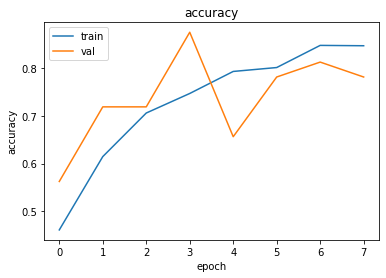

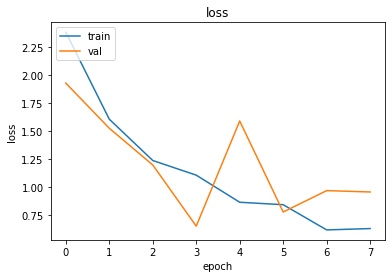

In [60]:
visualize_train(history_CNN)

In [61]:
results = model_CNN.evaluate(tf_test,  steps = total_num_test // batch_size)
print(results)

35/35 [==============================] - 1s 14ms/step - loss: 0.9289 - accuracy: 0.7812
[0.928906261920929, 0.78125]


In [62]:
y_pred_5k_C = model_CNN.predict(pad_x_test)
y_pred_5k_C = np.argmax(y_pred_5k_C, axis = 1)
print(classification_report(y_test_5k, y_pred_5k_C))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.72      0.89      0.79       105
           2       0.48      0.75      0.59        20
           3       0.91      0.95      0.93       813
           4       0.82      0.87      0.84       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.57      0.61      0.59        38
           9       0.76      0.88      0.81        25
          10       0.88      0.97      0.92        30
          11       0.74      0.66      0.70        83
          12       0.67      0.15      0.25        13
          13       0.64      0.57      0.60        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.65      0.86      0.74        99
          17       0.50    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test).argmax(axis=1)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

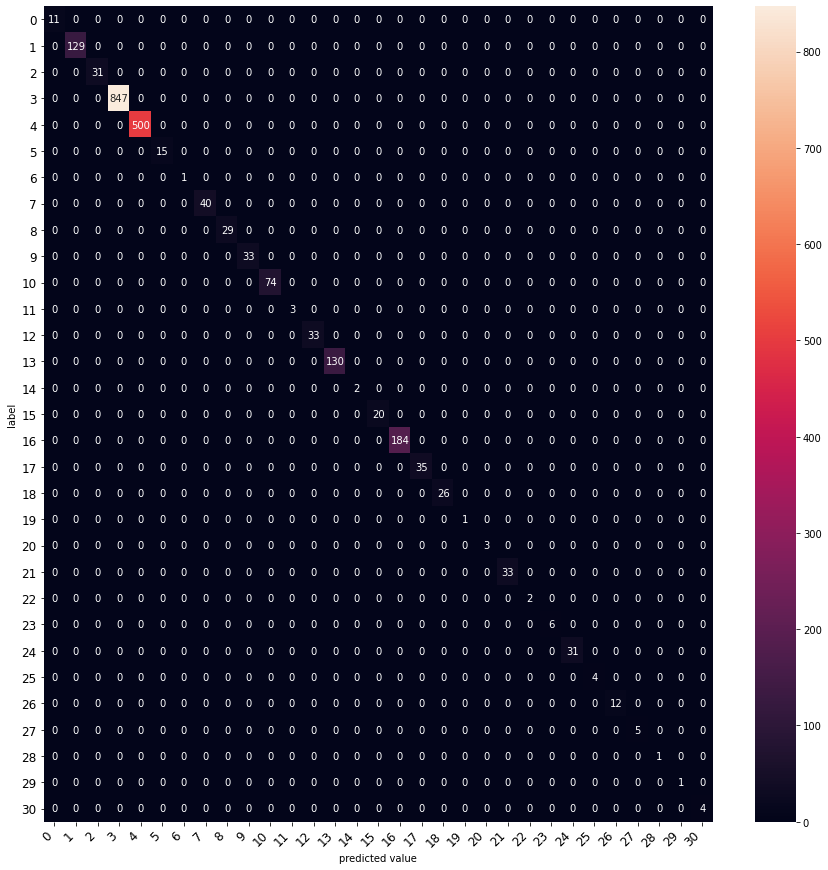

In [64]:
graph_confusion_matrix(model_CNN, pad_x_test, y_pred_5k_C)

### LSTM 모델
---

In [65]:
vocab_size = 5000
word_vector_dim = 100  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim))
model_LSTM.add(keras.layers.LSTM(128))
# model_LSTM.add(keras.layers.Dense(512, activation='relu'))
# model_LSTM.add(keras.layers.Dropout(0.3))
model_LSTM.add(keras.layers.Dense(128, activation='relu'))
# model_LSTM.add(keras.layers.Dropout(0.3))
model_LSTM.add(keras.layers.Dense(num_classes, activation='softmax'))  

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 46)                5934      
Total params: 639,694
Trainable params: 639,694
Non-trainable params: 0
_________________________________________________________________


In [66]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model_LSTM.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
            
epochs=20
batch_size=64

history_LSTM = model_LSTM.fit(tf_data,
              steps_per_epoch = buffer // batch_size,
              epochs = 20, validation_data = tf_data_val, validation_steps=1, callbacks = [es])



# history_LSTM = model_LSTM.fit(tfidfv_5k_arr,
#                                 y_train_5k,
#                                 epochs=epochs,
#                                 batch_size=batch_size,
#                                 callbacks=[es],
#                                 validation_split=0.2,
#                                 verbose=1)

Epoch 1/20
126/126 [==============================] - 43s 323ms/step - loss: 2.7983 - accuracy: 0.3309 - val_loss: 2.1688 - val_accuracy: 0.4688
Epoch 2/20
126/126 [==============================] - 40s 320ms/step - loss: 2.1182 - accuracy: 0.4625 - val_loss: 2.3063 - val_accuracy: 0.4375
Epoch 3/20
126/126 [==============================] - 40s 320ms/step - loss: 2.4009 - accuracy: 0.4011 - val_loss: 1.9765 - val_accuracy: 0.5000
Epoch 4/20
126/126 [==============================] - 40s 321ms/step - loss: 1.9662 - accuracy: 0.4840 - val_loss: 1.9110 - val_accuracy: 0.5000
Epoch 5/20
126/126 [==============================] - 40s 316ms/step - loss: 1.6783 - accuracy: 0.5535 - val_loss: 2.0943 - val_accuracy: 0.4688
Epoch 6/20
126/126 [==============================] - 40s 316ms/step - loss: 1.6432 - accuracy: 0.5707 - val_loss: 1.1252 - val_accuracy: 0.7812
Epoch 7/20
126/126 [==============================] - 42s 336ms/step - loss: 1.6037 - accuracy: 0.5828 - val_loss: 1.7669 - val_ac

In [67]:
results = model_LSTM.evaluate(tf_test,  steps = total_num_test // batch_size)
print(results)

35/35 [==============================] - 4s 109ms/step - loss: 1.5334 - accuracy: 0.6330
[1.5334010124206543, 0.6330357193946838]


In [79]:
y_pred_5k_l = model_LSTM.predict(pad_x_test)
y_pred_5k_l = np.argmax(y_pred_5k_l, axis = 1)
print(classification_report(y_test_5k, y_pred_5k_l))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.18      0.88      0.29       105
           2       0.00      0.00      0.00        20
           3       0.94      0.93      0.93       813
           4       0.71      0.90      0.80       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.26      0.10      0.14        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.34      0.15      0.21        99
          17       0.00    

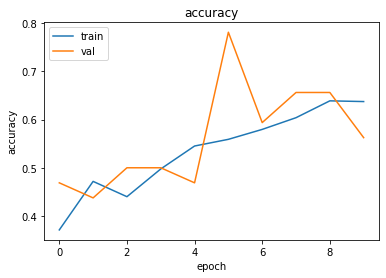

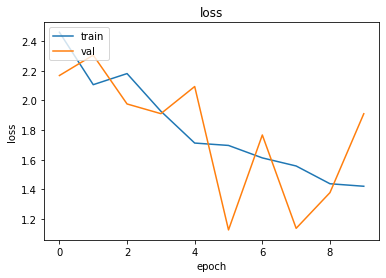

In [80]:
visualize_train(history_LSTM)

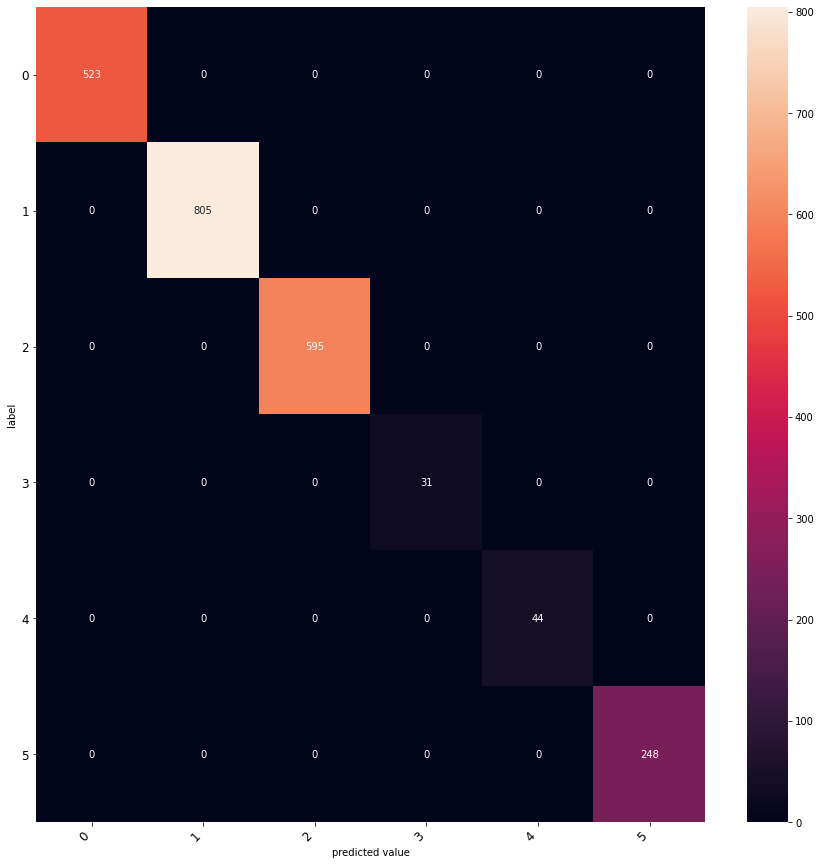

In [81]:
graph_confusion_matrix(model_LSTM, pad_x_test, y_pred_5k_l)

### 결과
---

최종적으로 전체 단어를 그대로 이용한 모델이 제일 우수한 정확도(약 0.8188)와 f1 score(약 0.8147)를 나타냈습니다.\
모델은 앙상블 기법을 이용하는 voting이 제일 높은 값을 보이고 있습니다.\
모델 중에 voting이 가장 높은 값을 나타내는 이유는 다른 모델들을 이용해서 결과에 대한 각각의 최종값을\
도출하는 방식이기 때문입니다.

다만 전체단어가 가장 높고 두 번째로 높은 값이 단어 수 5000개의 모델이어서,\
단어수는 voting모델에서 정확도를 올리는 데 중요한 지표가 아닐 수도 있겠다는 생각이 듭니다.\
물론 단어 수가 1000인 모델의 정확도 저하는 단어 수에 기인 할 수 있겠지만..

딥러닝 모델은 LSTM과 CNN 1-D 모델을 적용해서 생성했습니다.\
정확도는 다음과 같습니다.\
CNN 1-D는 0.7812\
LSTM은 0.6330

모두 단어 5000개의 voting모델에서 정확도는 약 0.8161입니다.\
따라서, 가장 좋은 성능을 보이는 것은 voting모델이었습니다.

### 회고
---
TF-IDF를 딥러닝에 그대로 적용해서 딥러닝모델을 생성해보려고 시도했지만,\
결국 텐서 사이즈가 일치하는 않는 오류가 뜨고,\
이를 해결해도 학습이 전혀 진행되지 않는 결과를 보여서(val정확도가 불변)\
결국, 창현님의 데이터셋 생성 코드를 퍼와서 딥러닝모델을 만들었습니다.\
텐서플로우 사용법에 대한 이해부족을 새삼 깊게 느끼게 된 노드였습니다.

그리고 이번에 classification_report결과를 읽는 방법을
https://blog.naver.com/PostView.naver?blogId=hannaurora&logNo=222498671200&parentCategoryNo=&categoryNo=41&viewDate=&isShowPopularPosts=true&from=search
를 통하여 알 수 있게 되었습니다.
